# Exploratory notebook
The analysis is based on the Gonzalo-Moser EC paper. 
* 1/28/24 setup
* TODO need to separate the awake and sleep epochs
* using spikes instead of Ca2+ data
* comparing locomotion and non locomotion

In [1]:
import os, sys
from os.path import dirname, join
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft
from scipy.stats import zscore

sys.path.append("/home/gergely/code/sleep/src")

from imaging_data_class import ImagingData
from suite2p_class import Suite2p as s2p
import imaging_data_class as idc
import behavior_class as bc

In [2]:
mice = [
    "140302_3"
]  # ["5HT2afl05b_1", "5HT2afl05b_2", "sert52b_1", "sert52b_5", "sert54a_5"]

In [3]:
mouse = ImagingData(mice[0])
mouse.mouse_id
s2p_folders = mouse.find_suite2p_folders()
for folder in enumerate(s2p_folders):
    print(folder)

Searching for suite2p folders in /data2/gergely/invivo_DATA/sleep/140302_3
(0, '/data2/gergely/invivo_DATA/sleep/140302_3/12_21/TSeries-12212023-1051-001/TSeries-12212023-1051-001.sima/suite2p')
(1, '/data2/gergely/invivo_DATA/sleep/140302_3/12_21/TSeries-12212023-1051-002/TSeries-12212023-1051-002.sima/suite2p')
(2, '/data2/gergely/invivo_DATA/sleep/140302_3/12_11/TSeries-12112023-0825_sess01-001/TSeries-12112023-0825_sess01-001_Cycle00001_Element00001.sima/suite2p')
(3, '/data2/gergely/invivo_DATA/sleep/140302_3/12_11/TSeries-12112023-0825_sess02_MC-002/TSeries-12112023-0825_sess02_MC-002.sima/suite2p')
(4, '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC_MC-003/TSeries-12132023-0849_GC_MC-003.sima/suite2p')
(5, '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC_dendrite-004/TSeries-12132023-0849_GC_dendrite-004.sima/suite2p')
(6, '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC-002/TSeries-12132023-0849_GC-002.

In [4]:
s2p_folder = s2p_folders[10]

In [5]:
s2p_data = s2p(s2p_folder)
spikes = s2p_data.get_spikes()
# z scoring
n_neurons, n_time = spikes.shape
spks = zscore(spikes, axis=1)

### Behavior

In [6]:
behavior = bc.behaviorData(mouse_id=mice[0])
behavior_folders = [
    (index, folder) for index, folder in enumerate(behavior.find_behavior_folders())
]
behavior_folders

Searching for behavior folders in /data2/gergely/invivo_DATA/sleep/140302_3
Searching for behavior folders in /data2/gergely/invivo_DATA/sleep/140302_3


[(0,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_21/TSeries-12212023-1051-001/TSeries-12212023-1051-001.sima/behavior'),
 (1,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_21/TSeries-12212023-1051-002/TSeries-12212023-1051-002.sima/behavior'),
 (2,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_11/TSeries-12112023-0825_sess01-001/TSeries-12112023-0825_sess01-001_Cycle00001_Element00001.sima/behavior'),
 (3,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_11/TSeries-12112023-0825_sess02_MC-002/TSeries-12112023-0825_sess02_MC-002.sima/behavior'),
 (4,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC_MC-003/TSeries-12132023-0849_GC_MC-003.sima/behavior'),
 (5,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC_dendrite-004/TSeries-12132023-0849_GC_dendrite-004.sima/behavior'),
 (6,
  '/data2/gergely/invivo_DATA/sleep/140302_3/12_13/TSeries-12132023-0849_GC-002/TSeries-12132023-0849_GC-002.sima/behavior'),
 (7,
  '/data2/gergely/in

In [7]:
beh_folder_to_load = 10
behavior_file = "140302_3_20231222154006_910_sleep.json"

In [8]:
processed_behavior = behavior_folders[beh_folder_to_load][1]

if not dirname(processed_behavior) == dirname(s2p_folder):
    raise ValueError("Behavior and imaging data folders do not match")

try:
    with open(join(processed_behavior, behavior_file), "r") as f:
        beh = json.load(f)
except FileNotFoundError:
    print("File not found")

In [9]:
with open(join(processed_behavior, "filtered_velocity.json"), "r") as f:
    speed = np.array(json.load(f))

position = np.array(beh[0]["data"]["treadmillPosition"])

with open(join(processed_behavior, "mobility_immobility.json"), "r") as f:
    mob_immob = np.array(json.load(f))

In [10]:
moving_spks = spks[:, mob_immob == 1]
notmoving_spks = spks[:, ~mob_immob == 1]

In [17]:
def calculate_autocorrelations(df):
    autocorrelations = []  # To store autocorrelation results
    for index, row in df.iterrows():
        signal = row.values
        autocorr = np.correlate(signal, signal, mode="full")
        autocorr = autocorr[autocorr.size // 2 :]  # Keep second half
        autocorr /= autocorr[0]  # Normalize
        autocorrelations.append(autocorr[:500])
    return np.array(autocorrelations)

In [12]:
def plot_heatmap(autocorrelations, title, ax):
    sns.heatmap(
        autocorrelations, cmap="viridis", cbar_kws={"label": "Autocorrelation"}, ax=ax
    )
    plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("Neuron Index")

## Calcluates and plots the autocorrelation of the traces. 

In [18]:
moving_autocorr = calculate_autocorrelations(moving_spks)
notmoving_autocorr = calculate_autocorrelations(notmoving_spks)

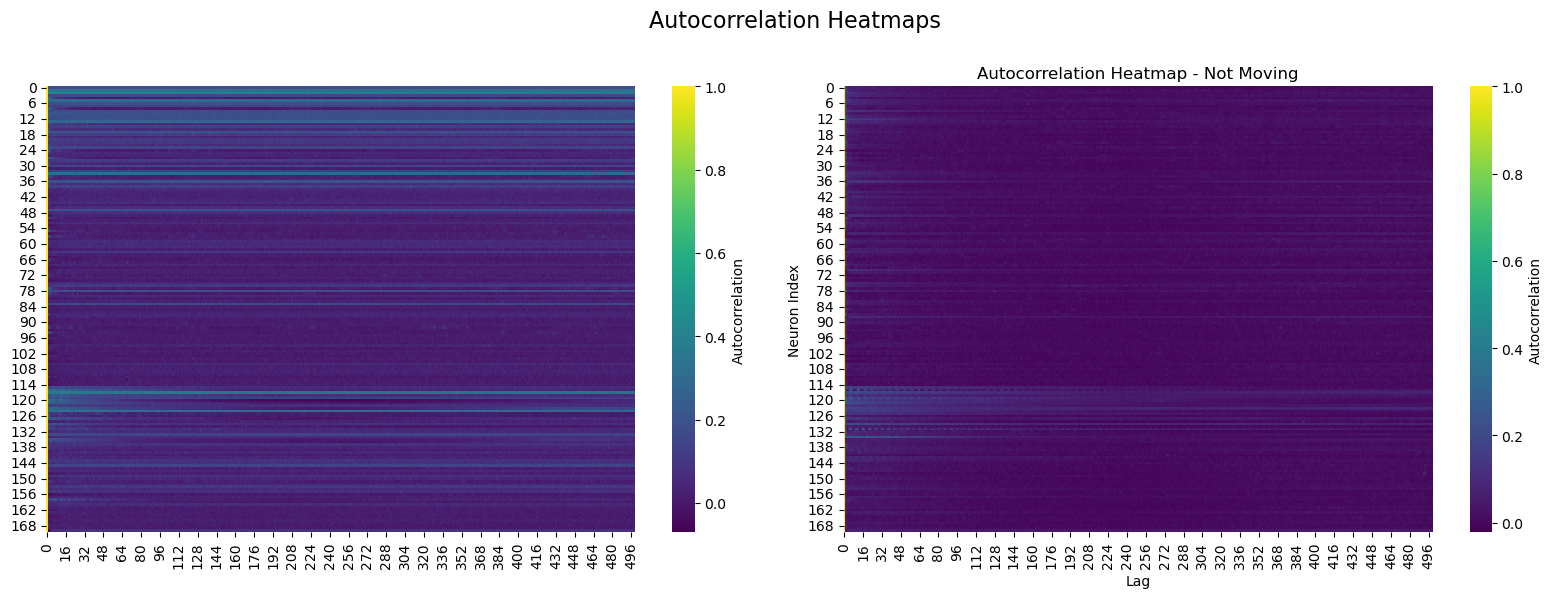

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting the heatmaps on specified axes
plot_heatmap(moving_autocorr, "Autocorrelation Heatmap - Moving", axes[0])
plot_heatmap(notmoving_autocorr, "Autocorrelation Heatmap - Not Moving", axes[1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Autocorrelation Heatmaps", fontsize=16, y=1.02)
plt.show()

## Calculating PSD of the traces

In [14]:
def calculate_psd_of_autocorrelation(data, sampling_rate, freq_range):
    """
    Calculate the Power Spectral Density (PSD) of the autocorrelations within a specific frequency range.

    Parameters:
    - data: numpy array of the input signals (2D: signals x time points).
    - sampling_rate: Sampling rate of the data in Hz.
    - freq_range: Tuple specifying the desired frequency range (min_freq, max_freq) within which the PSD is calculated.

    Returns:
    - freqs: Frequencies corresponding to the calculated PSD values within the specified range.
    - psd_values: PSD values within the specified frequency range.
    """
    psd_values = []
    for signal in data:
        # # Calculate autocorrelation
        # autocorr = np.correlate(signal, signal, mode="full")
        # autocorr = autocorr[autocorr.size // 2 :]  # Keep second half
        # autocorr /= autocorr[0]  # Normalize

        # Calculate PSD using the FFT of the autocorrelation
        psd = np.fft.fft(signal)
        psd = np.abs(psd) ** 2

        # Frequency bins
        freqs = np.fft.fftfreq(signal.size, d=1 / sampling_rate)

        # Limit PSD to desired frequency range
        freq_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
        psd_values.append(psd[freq_mask])

    freqs = freqs[freq_mask]  # Update freqs to match the limited range

    return freqs, np.array(psd_values)

In [12]:
def calculate_psd(data, sampling_rate, freq_range=None):
    """
    Calculate the Power Spectral Density (PSD) for a given signal.

    Parameters:
    - data: 2D numpy array of the input signals (signals x time points).
    - sampling_rate: Sampling rate of the data in Hz.
    - freq_range: Optional tuple specifying the frequency range (min_freq, max_freq) for the PSD calculation.

    Returns:
    - freqs: 1D numpy array of frequencies corresponding to the PSD values.
    - psd_values: 2D numpy array of PSD values (signals x PSD values).
    """
    n = data.shape[1]  # Number of data points
    freqs = np.fft.rfftfreq(n, d=1.0 / sampling_rate)
    psd_values = []

    for signal in data:
        # Compute the FFT and PSD
        fft_result = np.fft.rfft(signal)
        psd = np.abs(fft_result) ** 2 / n
        psd_values.append(psd)

    psd_values = np.array(psd_values)

    if freq_range is not None:
        # Limit PSD and frequencies to the specified range
        min_freq, max_freq = freq_range
        freq_mask = (freqs >= min_freq) & (freqs <= max_freq)
        freqs = freqs[freq_mask]
        psd_values = psd_values[:, freq_mask]

    return freqs, psd_values

In [16]:
moving_freq, moving_psd = calculate_psd(moving_spks, 20, (0, 0.1))
notmoving_freq, notmoving_psd = calculate_psd(notmoving_spks, 20, (0, 0.1))

In [17]:
def plot_psd(
    freqs,
    psd_values,
    ax,
    title="PSD of Autocorrelation",
    xlabel="Frequency (Hz)",
    ylabel="Power Spectral Density",
    label=None,
):
    """
    Plot a line plot of the Power Spectral Density (PSD) values.

    Parameters:
    - freqs: 1D numpy array of frequencies corresponding to the PSD values.
    - psd_values: 2D numpy array of PSD values for each signal (rows for signals, columns for PSD values).
    - ax: matplotlib.axes.Axes object where the plot will be drawn.
    - title: String, title of the plot.
    - xlabel: String, label for the x-axis.
    - ylabel: String, label for the y-axis.
    """
    # Plot the average PSD across all signals for simplicity
    # You can modify this to plot individual signals or a subset
    avg_psd = np.mean(psd_values, axis=0)
    ax.plot(freqs, avg_psd, label=label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

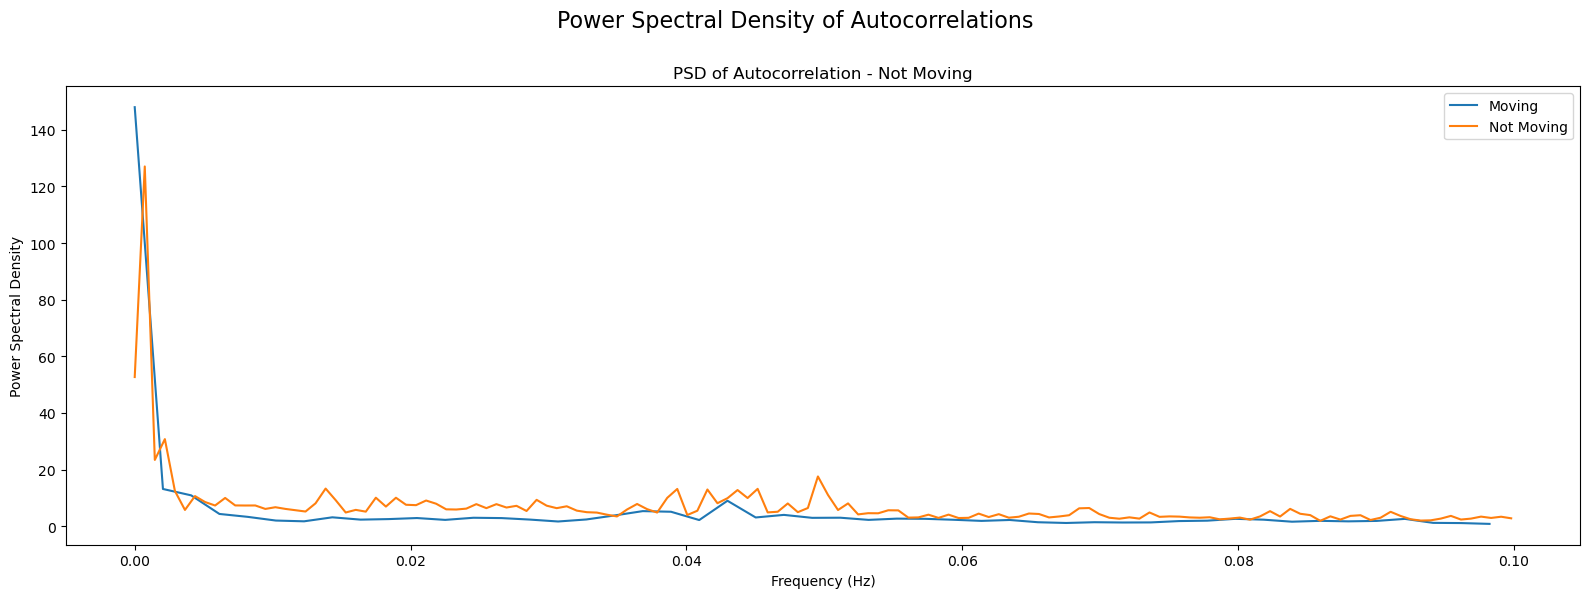

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
plot_psd(
    moving_freq,
    moving_psd,
    axes,
    title="PSD of Autocorrelation - Moving",
    label="Moving",
)
plot_psd(
    notmoving_freq,
    notmoving_psd,
    axes,
    title="PSD of Autocorrelation - Not Moving",
    label="Not Moving",
)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Power Spectral Density of Autocorrelations", fontsize=16, y=1.02)
plt.show()

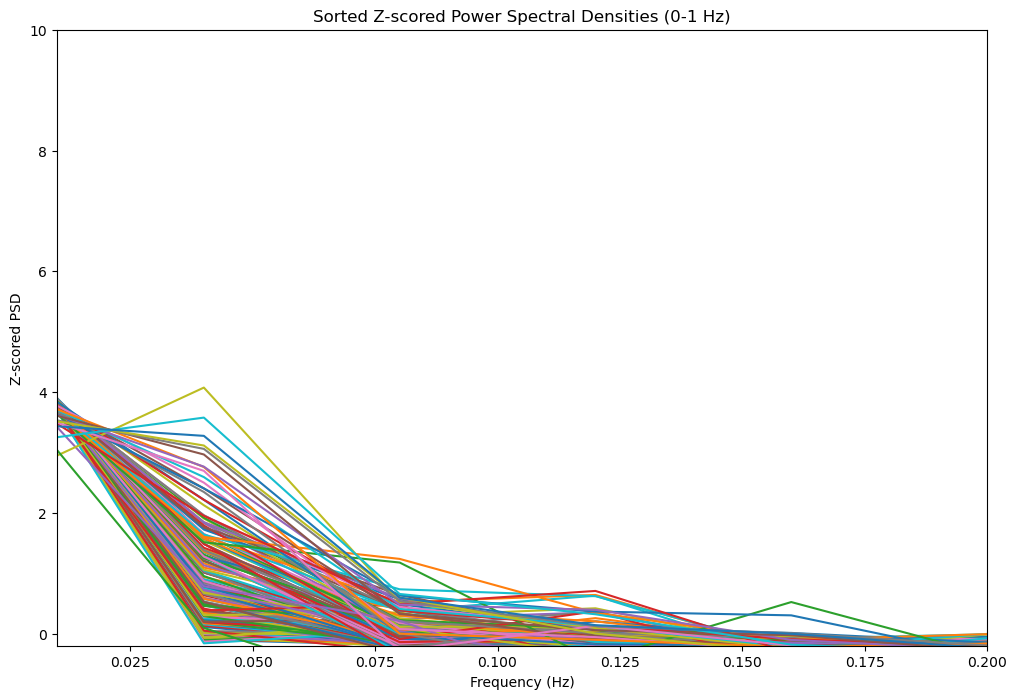

In [69]:
# Your sampling rate
sampling_rate = 20  # Replace with your actual sampling rate

# Length of the autocorrelation data
N = len(autocorrelations[0])

# Calculate the frequency values corresponding to FFT output
frequencies = np.fft.fftfreq(N, d=1 / sampling_rate)

# Indices for frequencies between 0 and 1 Hz
low_freq_indices = np.where((frequencies >= 0) & (frequencies <= 1))[0]

psd_list = []
for autocorr in autocorrelations:
    # Calculate the Fourier Transform
    psd = np.abs(fft(autocorr)) ** 2

    # Select the PSD components for 0-1 Hz
    psd_low_freq = psd[low_freq_indices]

    # Z-score normalization
    psd_z_scored = zscore(psd_low_freq)
    psd_list.append(psd_z_scored)

# Sorting based on the maximum power
psd_sorted = sorted(psd_list, key=lambda x: np.max(x), reverse=True)

# Plotting
plt.figure(figsize=(12, 8))
for psd in psd_sorted:
    plt.plot(
        frequencies[low_freq_indices], psd
    )  # Ensure the x-axis is using the selected frequencies
plt.title("Sorted Z-scored Power Spectral Densities (0-1 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Z-scored PSD")
plt.xlim(0.01, 0.2)  # Set x-axis limit to show only 0 to 1 Hz
plt.ylim(-0.2, 10)  # Set y-axis limit to show the PSDs
plt.show()

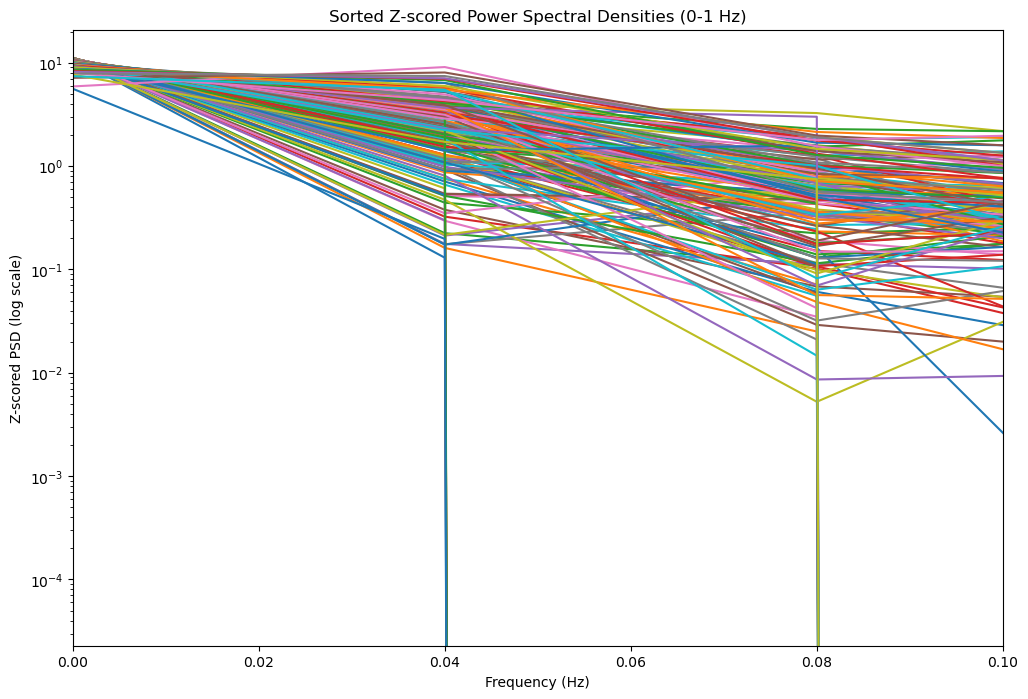

In [70]:
# Your sampling rate
sampling_rate = 20  # Replace with your actual sampling rate

# Length of the autocorrelation data
N = len(autocorrelations[0])

# Calculate the frequency values corresponding to FFT output
frequencies = np.fft.fftfreq(N, d=1 / sampling_rate)

# Indices for frequencies between 0 and 1 Hz
low_freq_indices = np.where((frequencies >= 0) & (frequencies <= 5))[0]

psd_list = []
for autocorr in autocorrelations:
    # Calculate the Fourier Transform
    psd = np.abs(fft(autocorr)) ** 2

    # Select the PSD components for 0-1 Hz
    psd_low_freq = psd[low_freq_indices]

    # Z-score normalization
    psd_z_scored = zscore(psd_low_freq)
    psd_list.append(psd_z_scored)

# Sorting based on the maximum power
psd_sorted = sorted(psd_list, key=lambda x: np.max(x), reverse=True)

# Plotting with semilogy
plt.figure(figsize=(12, 8))
for psd in psd_sorted:
    plt.semilogy(
        frequencies[low_freq_indices], psd
    )  # Use semilogy for logarithmic y-axis
plt.title("Sorted Z-scored Power Spectral Densities (0-1 Hz)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Z-scored PSD (log scale)")
plt.xlim(0, 0.1)  # Set x-axis limit to show only 0 to 1 Hz
plt.show()

Sliced PSDs ready for plotting.


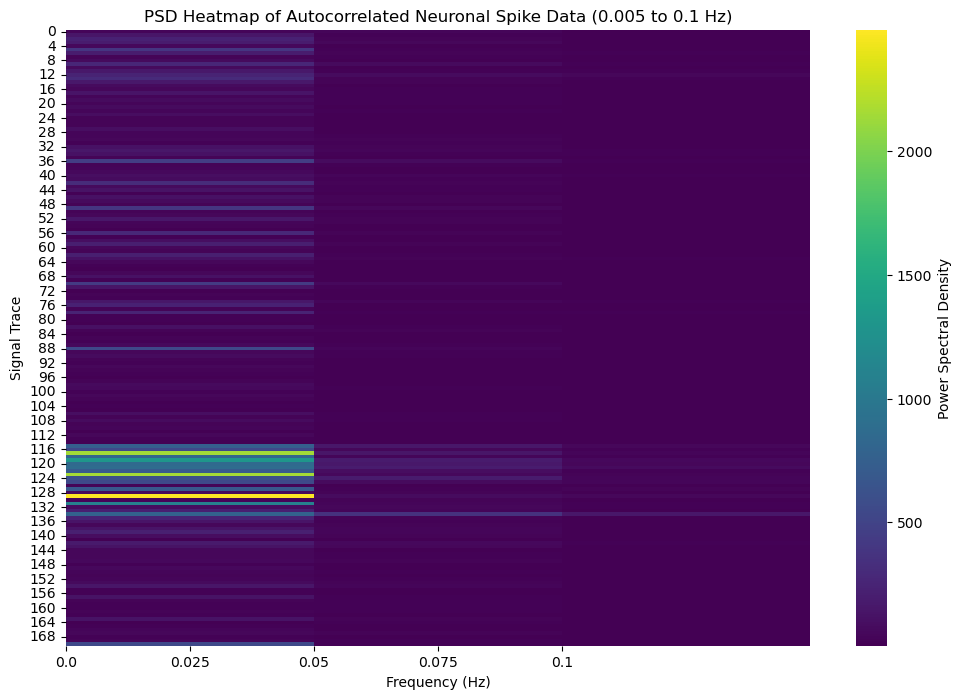

In [71]:
import numpy as np

# Given values
sampling_frequency = 20  # Hz
n = len(autocorrelations[0])  # Length of autocorrelation data

# Calculate frequency bins with correct resolution
freq_bins = np.fft.fftfreq(n, d=1.0 / sampling_frequency)

# Correctly identify indices for positive frequencies
positive_freq_indices = np.where(freq_bins > 0)[0]  # Only positive frequencies

# Find indices within the specified frequency range
min_freq = 0.00
max_freq = 0.1
desired_freq_indices = np.where((freq_bins >= min_freq) & (freq_bins <= max_freq))[0]

# If there are no indices found within the range, this indicates a potential issue
if len(desired_freq_indices) == 0:
    print(
        "No frequency bins found within the specified range. Consider checking the frequency range or the length of your data."
    )

# Assuming this part is correct, and you have PSDs calculated
# Ensure that you only use the positive frequency part for slicing
if len(desired_freq_indices) > 0:
    sliced_psds = [
        psd[desired_freq_indices]
        for psd in psds
        if len(psd) > max(desired_freq_indices)
    ]

    if not sliced_psds:
        print(
            "Sliced PSDs list is empty. Check if the PSD calculation or slicing went wrong."
        )
    else:
        # Continue with plotting as before, ensuring sliced_psds is not empty
        print("Sliced PSDs ready for plotting.")

# Plotting
plt.figure(figsize=(12, 8))
sns.heatmap(sliced_psds, cmap="viridis", cbar_kws={"label": "Power Spectral Density"})
# Adjust the x-axis to show actual frequency values
plt.xticks(
    ticks=np.linspace(0, len(desired_freq_indices) - 1, 5),
    labels=np.round(np.linspace(min_freq, max_freq, 5), 3),
)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Signal Trace")
plt.title("PSD Heatmap of Autocorrelated Neuronal Spike Data (0.005 to 0.1 Hz)")
plt.show()